# Libraries

In [1]:
import  pandas            as pd
import  numpy             as np
import  plotly.express    as px
import  matplotlib.pyplot as plt
import  plotly.graph_objs as go
import  plotly.io         as pio
from    datetime                import datetime
from    sklearn.decomposition   import PCA
from    sklearn.preprocessing   import StandardScaler
from    sklearn.ensemble        import RandomForestClassifier
from    xgboost                 import XGBClassifier
from    sklearn.model_selection import RandomizedSearchCV
from    sklearn.model_selection import cross_validate
from    sklearn.metrics         import make_scorer
from    sklearn.metrics         import accuracy_score
from    sklearn.metrics         import confusion_matrix
from    sklearn.metrics         import precision_score
from    sklearn.metrics         import recall_score
from    sklearn.metrics         import f1_score
from    sklearn.metrics         import roc_auc_score
from    sklearn.metrics         import ConfusionMatrixDisplay
from    sklearn.metrics         import RocCurveDisplay
from    imblearn.over_sampling  import SMOTE
from    plotly.subplots         import make_subplots
from    sklearn.model_selection import TunedThresholdClassifierCV
from    sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED = np.random.seed(31)

In [3]:
cd ..\

c:\Users\victo\Downloads\00. Estudo Data Science\predict_payment_default


c:\Users\victo\Downloads\00. Estudo Data Science\predict_payment_default\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# df train

In [4]:
df_train = pd.read_csv('data\processed\df_train.csv',
                       encoding='utf-8',
                       sep=','
                      )
df_train['SAFRA_REF'] = pd.to_datetime(df_train['SAFRA_REF']).dt.to_period('M')
df_train['DATA_CADASTRO'] = pd.to_datetime(df_train['DATA_CADASTRO'])
df_train['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_train['DATA_EMISSAO_DOCUMENTO'])
df_train['DATA_PAGAMENTO'] = pd.to_datetime(df_train['DATA_PAGAMENTO'])
df_train['DATA_VENCIMENTO'] = pd.to_datetime(df_train['DATA_VENCIMENTO'])
df_train.head()

,ID_CLIENTE,SAFRA_REF,DATA_CADASTRO,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,IDADE_ANOS_CLIENTE,UF_DDD,UF_CEP,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,INADIMP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0,241169.0,118.0
1,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1,0,241169.0,118.0
2,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1,0,241169.0,118.0
3,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,6,1,241169.0,118.0
4,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,0,241169.0,118.0


In [5]:
df_train.dtypes

ID_CLIENTE                         int64
SAFRA_REF                      period[M]
DATA_CADASTRO             datetime64[ns]
FLAG_PF                           object
SEGMENTO_INDUSTRIAL               object
DOMINIO_EMAIL                     object
PORTE                             object
IDADE_ANOS_CLIENTE               float64
UF_DDD                            object
UF_CEP                            object
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_PAGAMENTO            datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
DIAS_ATRASO                        int64
INADIMP                            int64
RENDA_MES_ANTERIOR               float64
NO_FUNCIONARIOS                  float64
dtype: object

In [6]:
df_train.isna().sum()

ID_CLIENTE                   0
SAFRA_REF                    0
DATA_CADASTRO                0
FLAG_PF                      0
SEGMENTO_INDUSTRIAL          0
DOMINIO_EMAIL                0
PORTE                        0
IDADE_ANOS_CLIENTE           0
UF_DDD                    9449
UF_CEP                       8
DATA_EMISSAO_DOCUMENTO       0
DATA_PAGAMENTO               0
DATA_VENCIMENTO              0
VALOR_A_PAGAR                0
TAXA                         0
DIAS_ATRASO                  0
INADIMP                      0
RENDA_MES_ANTERIOR           0
NO_FUNCIONARIOS              0
dtype: int64

# Dummies

In [7]:
columns_to_dummies = df_train.select_dtypes(exclude=['number']).columns
columns_to_dummies

Index(['SAFRA_REF', 'DATA_CADASTRO', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'UF_DDD', 'UF_CEP', 'DATA_EMISSAO_DOCUMENTO',
       'DATA_PAGAMENTO', 'DATA_VENCIMENTO'],
      dtype='object')

In [8]:
df_dummies = pd.get_dummies(df_train[columns_to_dummies],
                            drop_first=True, dtype=int)
df_dummies = df_dummies.select_dtypes(include=['number'])
df_dummies

,FLAG_PF_PJ,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,DOMINIO_EMAIL_BOL,DOMINIO_EMAIL_GMAIL,DOMINIO_EMAIL_HOTMAIL,DOMINIO_EMAIL_OUTLOOK,DOMINIO_EMAIL_YAHOO,PORTE_MEDIO,PORTE_PEQUENO,...,UF_CEP_PE,UF_CEP_PI,UF_CEP_PR,UF_CEP_RJ,UF_CEP_RN,UF_CEP_RS,UF_CEP_SC,UF_CEP_SE,UF_CEP_SP,UF_CEP_TO
0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77409,0,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
77410,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
77411,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77412,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [9]:
df_numeric_features = df_train.select_dtypes(include=['number']).drop(columns=['INADIMP', 'ID_CLIENTE'])
X_train_val_encoded = pd.concat([df_numeric_features, df_dummies], axis=1)
X_train_val_encoded.dropna(inplace=True)
X_train_val_encoded.head()

,IDADE_ANOS_CLIENTE,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF_PJ,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,DOMINIO_EMAIL_BOL,...,UF_CEP_PE,UF_CEP_PI,UF_CEP_PR,UF_CEP_RJ,UF_CEP_RN,UF_CEP_RS,UF_CEP_SC,UF_CEP_SE,UF_CEP_SP,UF_CEP_TO
0,11.0,35516.41,6.99,0,241169.0,118.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,11.0,17758.21,6.99,1,241169.0,118.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,11.0,17431.96,6.99,1,241169.0,118.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,11.0,1341.00,6.99,6,241169.0,118.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,11.0,21309.85,6.99,0,241169.0,118.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
y_train_val = df_train['INADIMP'].iloc[X_train_val_encoded.index]
y_train_val

0        0
1        0
2        0
3        1
4        0
        ..
77409    1
77410    0
77411    0
77412    0
77413    0
Name: INADIMP, Length: 77414, dtype: int64

In [11]:
y_train_val.value_counts()

INADIMP
0    71978
1     5436
Name: count, dtype: int64

# Balance data

In [12]:
# Balance train_val data minority class
oversample = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)
oversample.fit(X_train_val_encoded, y_train_val)

SMOTE(sampling_strategy='minority')

In [13]:
# Data balanced
X_train_val_balanced, y_train_val_balanced = oversample.fit_resample(X_train_val_encoded, y_train_val)

In [14]:
y_train_val_balanced.value_counts()

INADIMP
0    71978
1    71978
Name: count, dtype: int64

# Scale data

In [15]:
scaler = StandardScaler()
scaler.fit(X_train_val_balanced)
X_train_val_scaled = scaler.transform(X_train_val_balanced)
X_train_val_scaled = pd.DataFrame(X_train_val_scaled,
                              columns=X_train_val_balanced.columns,
                              index=X_train_val_balanced.index
                              )
X_train_val_scaled.dropna(inplace=True)
X_train_val_scaled.head()

,IDADE_ANOS_CLIENTE,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF_PJ,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,DOMINIO_EMAIL_BOL,...,UF_CEP_PE,UF_CEP_PI,UF_CEP_PR,UF_CEP_RJ,UF_CEP_RN,UF_CEP_RS,UF_CEP_SC,UF_CEP_SE,UF_CEP_SP,UF_CEP_TO
0,-0.562594,-0.059962,0.100423,-0.297990,-0.121028,0.019357,-0.046154,-0.452062,1.254939,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228495,-0.034587,-0.226756,-0.18438,-0.037018,-0.362382,-0.070502
1,-0.562594,-0.342761,0.100423,-0.263951,-0.121028,0.019357,-0.046154,-0.452062,1.254939,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228495,-0.034587,-0.226756,-0.18438,-0.037018,-0.362382,-0.070502
2,-0.562594,-0.347956,0.100423,-0.263951,-0.121028,0.019357,-0.046154,-0.452062,1.254939,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228495,-0.034587,-0.226756,-0.18438,-0.037018,-0.362382,-0.070502
3,-0.562594,-0.604204,0.100423,-0.093753,-0.121028,0.019357,-0.046154,-0.452062,1.254939,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228495,-0.034587,-0.226756,-0.18438,-0.037018,-0.362382,-0.070502
4,-0.562594,-0.286201,0.100423,-0.297990,-0.121028,0.019357,-0.046154,-0.452062,1.254939,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228495,-0.034587,-0.226756,-0.18438,-0.037018,-0.362382,-0.070502


# PCA

In [16]:
pca = PCA()
pca.fit(X_train_val_scaled)

PCA()

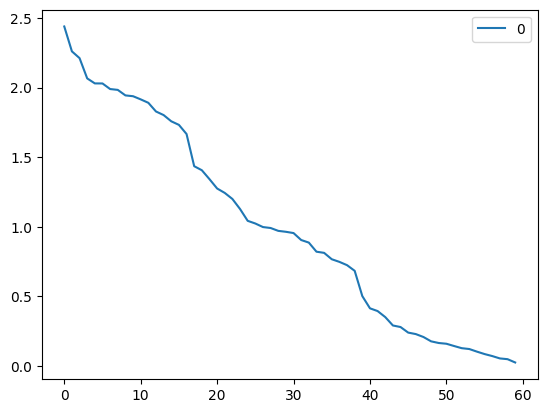

In [17]:
# Eigenvalues
df_explained_variance = pd.DataFrame(pca.explained_variance_)
df_explained_variance.plot()
plt.show()

In [18]:
# Eigenvector
df_components = pd.DataFrame(pca.components_)
df_components.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.297985,-0.030949,0.025046,0.061665,0.058770,0.083357,-0.002911,-0.208848,0.204819,-0.094600,...,-0.022587,0.014362,-0.087598,-0.025716,-0.015699,0.009802,-0.157958,0.011222,0.389020,-0.009961
1,0.045795,0.060861,-0.050592,-0.047793,0.024568,-0.260929,0.043655,0.029653,0.050366,-0.156096,...,0.025917,-0.016560,-0.035498,-0.032649,-0.000893,0.078157,-0.049697,0.060231,0.059545,-0.003692
2,0.137481,0.065714,0.030866,-0.043037,0.030746,-0.041723,-0.065579,0.224565,-0.177234,-0.183944,...,0.065065,-0.021639,0.016984,0.050334,-0.010547,0.159237,-0.034891,-0.042935,0.159037,-0.005881
3,-0.073087,-0.051992,-0.019851,0.016315,-0.028136,-0.092371,0.028077,0.005062,0.105000,0.088206,...,-0.075686,-0.012817,-0.120307,-0.122372,-0.014339,-0.040299,-0.318555,0.013237,-0.091451,0.010838
4,0.142651,0.007130,-0.013994,-0.081885,0.076785,-0.048426,-0.017682,0.006956,-0.069048,0.128090,...,-0.028151,-0.024006,-0.089777,0.098315,0.001517,0.018927,-0.121734,0.013413,0.075197,0.019559


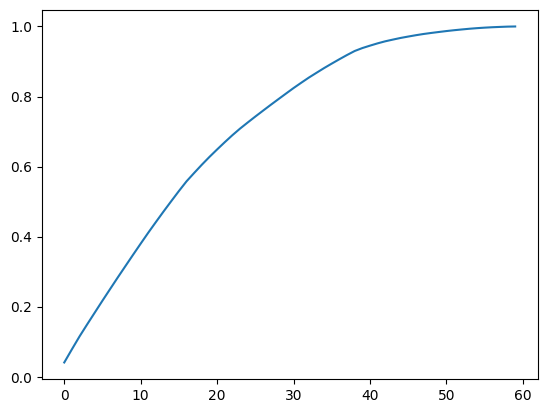

In [19]:
# Explained variance
df_explained_var_ratio = pd.DataFrame(pca.explained_variance_ratio_)
df_explained_var_ratio['cumsum'] = df_explained_var_ratio.cumsum()
df_explained_var_ratio['cumsum'].plot()
plt.show()

In [20]:
# N components for 90% explained variation ratio
n_components = df_explained_var_ratio[df_explained_var_ratio['cumsum'] >= 0.9].index[0]
n_components

36

In [21]:
pca_new = PCA(n_components=n_components)
pca_new.fit(X_train_val_scaled)
X_train_val_pca = pd.DataFrame(pca_new.transform(X_train_val_scaled))

# Rename columns to PC_number
X_train_val_pca.columns = ['PC' + str(i) for i in range(1, n_components + 1)]
X_train_val_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,-1.193092,1.200131,2.599985,3.558485,-2.059934,-0.625523,0.498170,0.083373,-3.071229,-1.151773,...,-0.702640,-0.748326,-2.373111,-0.688839,-0.496477,-1.557146,-2.037407,3.190578,-0.304266,-1.158299
1,-1.182241,1.181293,2.579936,3.573743,-2.064737,-0.624969,0.503900,0.068761,-3.074246,-1.146161,...,-0.757810,-0.906026,-2.391361,-0.718237,-0.611101,-1.655780,-2.045595,3.212487,-0.268169,-1.064318
2,-1.182080,1.180977,2.579595,3.574014,-2.064774,-0.624936,0.503995,0.068508,-3.074280,-1.146037,...,-0.758730,-0.909091,-2.391811,-0.718854,-0.613173,-1.657698,-2.045641,3.212767,-0.267898,-1.062733
3,-1.163654,1.157247,2.555431,3.590113,-2.080538,-0.629434,0.511380,0.051893,-3.081857,-1.145734,...,-0.829410,-1.014646,-2.382737,-0.728223,-0.724687,-1.723465,-2.076328,3.259959,-0.147813,-0.945883
4,-1.186090,1.186362,2.585118,3.570247,-2.061547,-0.624103,0.502325,0.072343,-3.072696,-1.146349,...,-0.742733,-0.881783,-2.392715,-0.715732,-0.586681,-1.640667,-2.039410,3.202762,-0.292463,-1.089307


# Split data

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_pca,
                                                  y_train_val_balanced,
                                                  train_size=0.8,
                                                  random_state=RANDOM_SEED,
                                                  )

# Functions

In [23]:
def plot_cross_validation_score(cv_results, score):
    """
    Plots the cross-validation scores for training and validation datasets.
    
    Parameters:
        cv_results (dict): A dictionary containing the cross-validation results.
                            It should have keys 'train_<score>' and 'test_<score>'.
        score (str): The metric to be plotted. For example, 'accuracy' or 'loss'.
    
    Returns: None
                This function displays a plot and does not return any value.
    """
    plot_fig, plot_ax = plt.subplots(figsize=(8, 4))
    plot_ax.plot(cv_results[f'train_{score}'],
                 marker='o',
                 linestyle='-',
                 color='blue',
                 label='Train'
                )
    plot_ax.plot(cv_results[f'test_{score}'],
                 marker='o',
                 linestyle='-',
                 color='red',
                 label='Validation'
                )
    plot_ax.set_xlabel('Iteration')
    plot_ax.set_xticks(range(1, len(cv_results[f'train_{score}'])))
    plot_ax.set_ylabel('Score')
    plot_ax.set_title(f'Cross-validation {score} score')
    plot_ax.legend()
    plot_ax.grid(True)

In [24]:
def calculate_feature_importance(model, importance):
    """
    Calculates and plots the feature importance from a model.
    
    Parameters:
        model: A trained model that has 'feature_importances_' and 'feature_names_in_' attributes.
                    Typically, this would be a tree-based model like RandomForest, GradientBoosting, etc.
        importance: The threshold below which feature importance are filtered out. 
    
    Returns:
        DataFrame: A DataFrame containing the features and their importance, sorted in ascending order and
                    filtered to show only features with importance greater than zero.
    
    This function performs the following steps:
        1. Extracts the feature importance from the model.
        2. Creates a DataFrame with features and their importance.
        3. Plots a boxplot of feature importance.
        4. Filters features with importance greater than zero.
        5. Plots a bar chart of features with non-zero importance.
    """
    # Calculate feature importance (Gini)
    feat_importance    = model.feature_importances_
    df_feat_importance = pd.DataFrame({'feature'   : model.feature_names_in_,
                                       'importance': feat_importance}
                                      ).sort_values('importance', ascending=True)
    df_feat_importance.reset_index(drop=True, inplace=True)
    plt.figure(figsize=(8, 4))
    plt.boxplot(x=df_feat_importance['importance'], vert=False)
    plt.xlabel('Importance')
    plt.title('Feature importance distribution')

    df_feat_importance_no_zero = df_feat_importance[df_feat_importance['importance'] > importance]
    plt.figure(figsize=(8, 10))
    plt.barh(df_feat_importance_no_zero['feature'], df_feat_importance_no_zero['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'{df_feat_importance_no_zero.shape[0]} importance greater than {importance}')

    return df_feat_importance_no_zero

In [53]:
def calculate_metrics_range_cutoff(dataframe_predict_proba, y_true):
    results = []
    for cutoff in np.arange(0.05, 0.99, 0.02):
        y_predict      = np.where(dataframe_predict_proba['proba_event'] > cutoff, 1, 0)
        accuracy       = accuracy_score(y_true, y_predict)
        precision      = precision_score(y_true, y_predict, zero_division=0)
        recall         = recall_score(y_true, y_predict, zero_division=0)
        f1score        = f1_score(y_true, y_predict, zero_division=0)
        auc_value      = roc_auc_score(y_true, y_predict)
        tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
        specificity    = tn / (tn + fp)

        false_positive_rate       = fp / (fp + tn) * 100
        false_negative_rate       = fn / (fn + tp) * 100
        false_classification_rate = (fp + fn) / y_predict.shape[0] * 100
                                
        results.append([cutoff, accuracy, precision,
                        recall, f1score,
                        auc_value, tn, fp, fn, tp,
                        specificity, false_positive_rate,
                        false_negative_rate, false_classification_rate]
                    )
        
        df_metrics = pd.DataFrame(results,
                                  columns=['cutoff', 'accuracy', 'precision',
                                           'recall', 'f1score' , 'auc_value',
                                           'tn', 'fp', 'fn', 'tp',
                                           'specificity', 'false_positive_rate',
                                           'false_negative_rate', 'false_classification_rate']
                                 )
        
    return df_metrics

In [71]:
def plot_metrics(dataframe_proba):
    fig = make_subplots(rows=2, cols=1,
                        vertical_spacing=0.13,
                        horizontal_spacing=0.06,
                        shared_xaxes=False,
                        subplot_titles=['Classifications', 'Metrics']
                        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['fn'],
        name='FN',
        mode='lines',
        line=dict(color='#eb3040')
        ),
        row=1, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['fp'],
        name='FP',
        mode='lines',
        line=dict(color='#eb6949')
        ),
        row=1, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['tp'],
        name='TP',
        mode='lines',
        line=dict(color='#eb8d27')
        ),
        row=1, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['tn'],
        name='TN',
        mode='lines',
        line=dict(color='#ad267e')
        ),
        row=1, col=1
        )

    # ***********************************************
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['accuracy'],
        name='Accuracy',
        mode='lines',
        line=dict(color='#85ab71')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['precision'],
        name='Precision',
        mode='lines',
        line=dict(color='#5e8d6f')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['recall'],
        name='Recall',
        mode='lines',
        line=dict(color='#58b69e')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['f1score'],
        name='F1-score',
        mode='lines',
        line=dict(color='#c87499')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['specificity'],
        name='Specificity',
        mode='lines',
        line=dict(color='#cb4d8e')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['auc_value'],
        name='AUC',
        mode='lines',
        line=dict(color='#988921')
        ),
        row=2, col=1
        )
    
    fig.update_layout(height=850,
                      width=1000,
                      showlegend=True,
                      margin=dict(l=10, r=10, b=10, t=30, pad=0),
                      xaxis1=dict(title='Cutoff', dtick=0.02, range=(0, 1)),
                      xaxis2=dict(title='Cutoff', dtick=0.02, range=(0, 1)),
                      yaxis1=dict(title='%'),
                      yaxis2=dict(title='')
                      )

    fig.show()

In [34]:
def calculate_metrics_selected_cutoff(dataframe_predict_proba, y_true, cutoff=0.5):
    y_predict      = np.where(dataframe_predict_proba['proba_event'] > cutoff, 1, 0)
    accuracy       = accuracy_score(y_true, y_predict)
    precision      = precision_score(y_true, y_predict, zero_division=0)
    recall         = recall_score(y_true, y_predict, zero_division=0)
    f1score        = f1_score(y_true, y_predict, zero_division=0)
    auc_value      = roc_auc_score(y_true, y_predict)
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
    specificity    = tn / (tn + fp)

    false_positive_rate       = fp / (fp + tn) * 100
    false_negative_rate       = fn / (fn + tp) * 100
    false_classification_rate = (fp + fn) / y_predict.shape[0] * 100
    
    metrics = []
    metrics.append([accuracy,
                    precision,
                    recall,
                    f1score,
                    auc_value,
                    specificity,
                    tn, fp, fn, tp,
                    false_positive_rate,
                    false_negative_rate,
                    false_classification_rate]  
                  )
    print(f'Accuracy:        {accuracy:.2f}')
    print(f'Precision:       {precision:.2f}')
    print(f'Recall:          {recall:.2f}')
    print(f'F1-score:        {f1score:.2f}')
    print(f'Specificity:     {specificity:.2f}')
    print(f'AUC:             {auc_value:.2f}\n')
    print(f'TN:              {tn:.2f}')
    print(f'TP:              {tp:.2f}')
    print(f'FN:              {fn:.2f}')
    print(f'FP:              {fp:.2f}\n')
    print(f'FP rate:         {false_positive_rate:.2f}%')
    print(f'FN rate:         {false_negative_rate:.2f}%')
    print(f'False clf rate:  {false_classification_rate:.2f}%\n')

    cm = confusion_matrix(y_true, y_predict)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_predict).plot

    return metrics

# Random forest

In [27]:
parameters_rf_clf = {
    "model_parameters": {
        "n_estimators": [10, 50, 100, 200],
        "criterion": ["gini"],
        "max_depth": [2, 13],
        "min_samples_split": [0.2, 1],
        "min_samples_leaf": [1, 7]
    },
    "cross_validation": {
        "n_iterations": 5,
        "folders": 5,
        "scores": [
            "recall",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "rand_forest",
    "predict_method": "predict_proba"
}

In [28]:
def create_hyper_parameters_rf_clf(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=5
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=2
                                )
    range_min_samples_split = np.arange(start=round(parameters.get('model_parameters')['min_samples_split'][0], 2),
                                        stop=round(parameters.get('model_parameters')['min_samples_split'][-1], 2),
                                        step=0.1
                                        )
    range_min_samples_leaf = np.arange(start=round(parameters.get('model_parameters')['min_samples_leaf'][0], 2),
                                       stop=round(parameters.get('model_parameters')['min_samples_leaf'][-1], 2),
                                       step=1
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'min_samples_split': range_min_samples_split,
                           'min_samples_leaf' : range_min_samples_leaf
                          }
    
    return param_distributions

## Simple model

In [29]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

### Cross-validation scores

[CV] END .................................................... total time= 1.3min
[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time= 1.8min
[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.7min
>>>>>>>>> CV recall train: mean 1.0, std 0.0
>>>>>>>>> CV recall test:  mean 0.98,  std 0.0012
>>>>>>>>> CV f1_macro train: mean 1.0, std 0.0
>>>>>>>>> CV f1_macro test:  mean 0.9859,  std 0.0006
>>>>>>>>> CV roc_auc train: mean 1.0, std 0.0
>>>>>>>>> CV roc_auc test:  mean 0.9982,  std 0.0001
>>>>>>>>> CV precision_macro train: mean 1.0, std 0.0
>>>>>>>>> CV precision_macro test:  mean 0.986,  std 0.0006


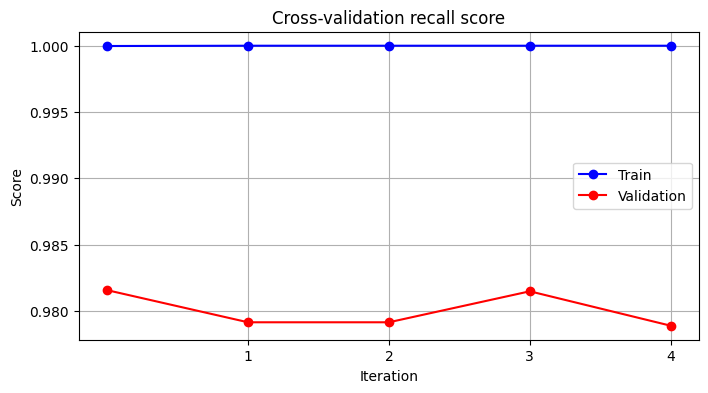

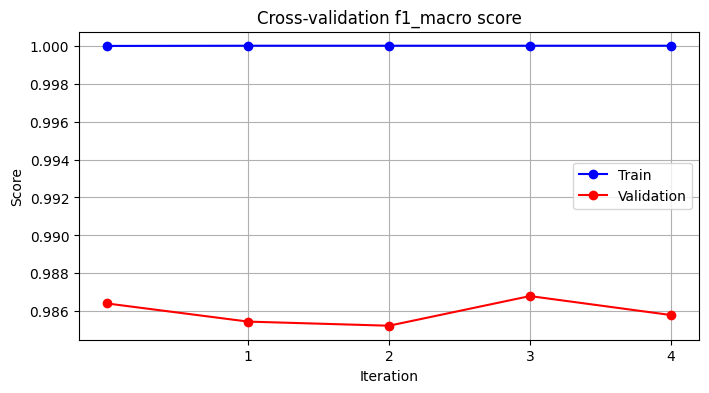

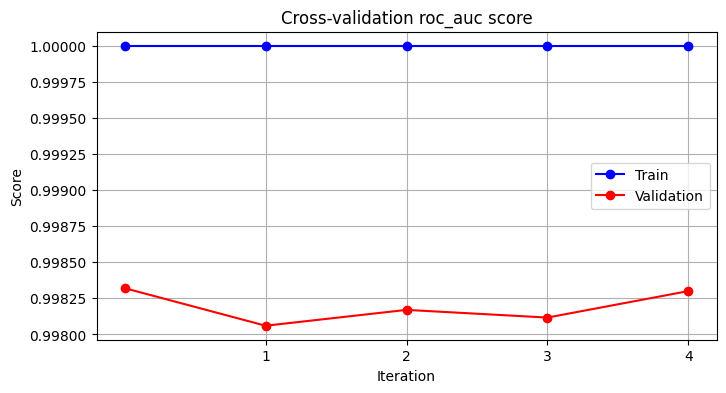

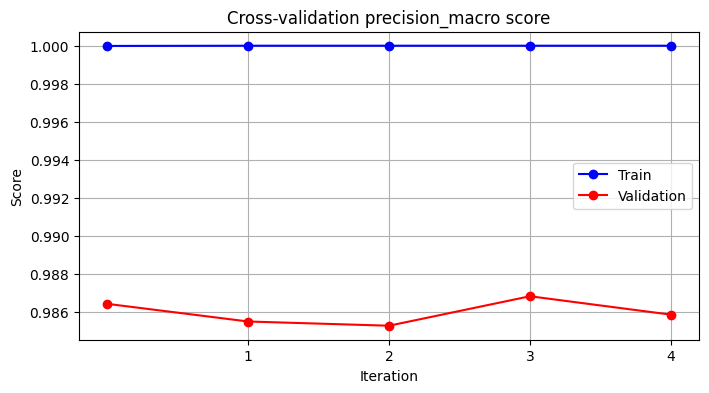

In [30]:
cv_results_rf_clf = cross_validate(estimator=rf_clf,
                                   X=X_train,
                                   y=y_train,
                                   scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                   cv=parameters_rf_clf.get('cross_validation')['folders'],
                                   verbose=2,
                                   return_train_score=True,
                                   error_score=np.nan
                                   )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf[f'train_{score}'].mean().round(4)
    cv_train_std  = cv_results_rf_clf[f'train_{score}'].std().round(4)
    cv_test_mean  = cv_results_rf_clf[f'test_{score}'].mean().round(4)
    cv_test_std   = cv_results_rf_clf[f'test_{score}'].std().round(4)
    plot_cross_validation_score(cv_results_rf_clf, score)
    print(f'>>>>>>>>> CV {score} train: mean {cv_train_mean}, std {cv_train_std}')
    print(f'>>>>>>>>> CV {score} test:  mean {cv_test_mean},  std {cv_test_std}')

In [31]:
y_val_pred_proba_rf_clf = rf_clf.predict_proba(X_val)
df_y_val_pred_proba_rf_clf = pd.DataFrame(y_val_pred_proba_rf_clf,
                                   columns=['proba_non_event', 'proba_event'])
df_y_val_pred_proba_rf_clf.head()

,proba_non_event,proba_event
0,0.98,0.02
1,0.00,1.00
2,0.00,1.00
3,1.00,0.00
4,0.03,0.97


In [55]:
df_metrics_rf_clf = calculate_metrics_range_cutoff(df_y_val_pred_proba_rf_clf, y_true=y_val)
df_metrics_rf_clf.head()

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate
0,0.05,0.931717,0.880055,0.997536,0.935120,0.932588,12658,1931,35,14168,0.867640,13.236000,0.246427,6.828286
1,0.07,0.947520,0.906170,0.996832,0.949341,0.948172,13123,1466,45,14158,0.899513,10.048667,0.316834,5.247986
2,0.09,0.957349,0.923438,0.996128,0.958407,0.957862,13416,1173,55,14148,0.919597,8.040304,0.387242,4.265074
3,0.11,0.964539,0.936664,0.995424,0.965150,0.964947,13633,956,65,14138,0.934471,6.552882,0.457650,3.546124
4,0.13,0.969262,0.945955,0.994508,0.969624,0.969596,13782,807,78,14125,0.944684,5.531565,0.549180,3.073770


In [72]:
plot_metrics(df_metrics_rf_clf)

Accuracy:        0.99
Precision:       0.99
Recall:          0.99
F1-score:        0.99
Specificity:     0.99
AUC:             0.99

TN:              14410.00
TP:              14030.00
FN:              173.00
FP:              179.00

FP rate:         1.23%
FN rate:         1.22%
False clf rate:  1.22%



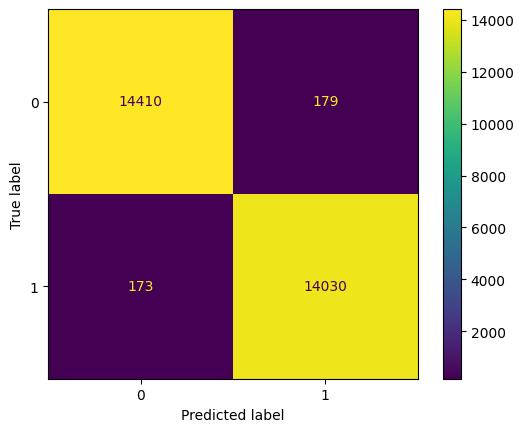

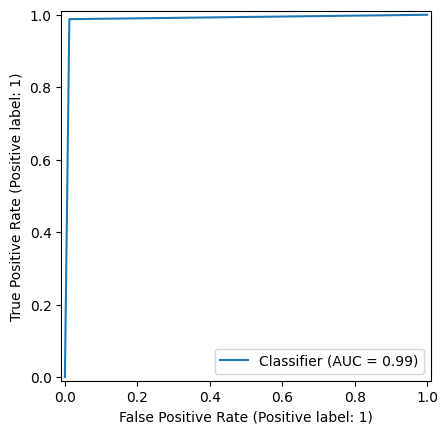

In [ ]:
selected_cutoff_rf_clf = 0.37
df_metrics_selected_cutoff_rf_clf = calculate_metrics_selected_cutoff(df_y_val_pred_proba_rf_clf,
                                                                      y_true=y_val,
                                                                      cutoff=selected_cutoff_rf_clf
                                                                      )

## Tuning

In [75]:
param_dist_rf_clf = create_hyper_parameters_rf_clf(parameters_rf_clf)
param_dist_rf_clf

{'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
         75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
        140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]),
 'max_depth': array([ 2,  4,  6,  8, 10, 12]),
 'min_samples_split': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'min_samples_leaf': array([1, 2, 3, 4, 5, 6])}

In [76]:
random_search_rf_clf = RandomizedSearchCV(estimator=rf_clf,
                                          param_distributions=param_dist_rf_clf,
                                          verbose=3,
                                          cv=parameters_rf_clf.get('cross_validation')['folders'],
                                          n_iter=parameters_rf_clf.get('cross_validation')['n_iterations'],
                                          random_state=RANDOM_SEED,
                                          scoring=make_scorer(roc_auc_score)
                                          )
random_search_rf_clf.fit(X_train, y_train)

best_params_rf_clf = random_search_rf_clf.best_params_
rf_clf_tuning = RandomForestClassifier(**best_params_rf_clf, random_state=RANDOM_SEED)
rf_clf_tuning.fit(X_train, y_train)
print(f'\nBest parameters:\n{best_params_rf_clf}\n')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_depth=8, min_samples_leaf=1, min_samples_split=0.7000000000000002, n_estimators=135;, score=0.500 total time=   0.9s
[CV 2/5] END max_depth=8, min_samples_leaf=1, min_samples_split=0.7000000000000002, n_estimators=135;, score=0.500 total time=   0.9s
[CV 3/5] END max_depth=8, min_samples_leaf=1, min_samples_split=0.7000000000000002, n_estimators=135;, score=0.500 total time=   0.9s
[CV 4/5] END max_depth=8, min_samples_leaf=1, min_samples_split=0.7000000000000002, n_estimators=135;, score=0.500 total time=   0.8s
[CV 5/5] END max_depth=8, min_samples_leaf=1, min_samples_split=0.7000000000000002, n_estimators=135;, score=0.500 total time=   0.8s
[CV 1/5] END max_depth=8, min_samples_leaf=2, min_samples_split=0.30000000000000004, n_estimators=125;, score=0.836 total time=  12.7s
[CV 2/5] END max_depth=8, min_samples_leaf=2, min_samples_split=0.30000000000000004, n_estimators=125;, score=0.835 total time=  12.9s


### Cross-validation scores

>>>>>>>>> CV recall train: mean 0.722, std 0.0057
>>>>>>>>> CV recall test:  mean 0.7215,  std 0.006
>>>>>>>>> CV f1_macro train: mean 0.8364, std 0.0028
>>>>>>>>> CV f1_macro test:  mean 0.8361,  std 0.0033
>>>>>>>>> CV roc_auc train: mean 0.9003, std 0.001
>>>>>>>>> CV roc_auc test:  mean 0.8996,  std 0.0026
>>>>>>>>> CV precision_macro train: mean 0.8583, std 0.0057
>>>>>>>>> CV precision_macro test:  mean 0.858,  std 0.0059


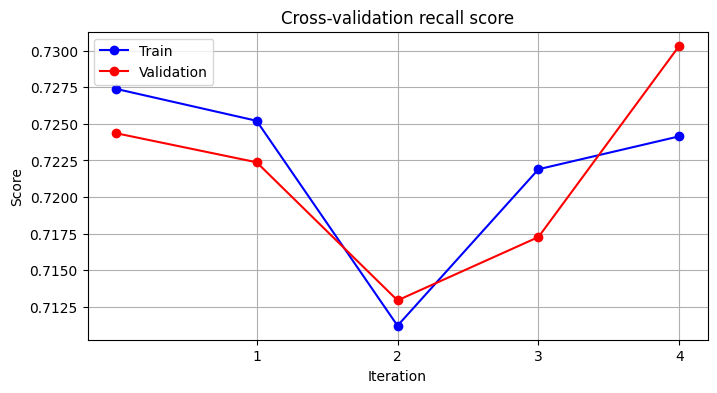

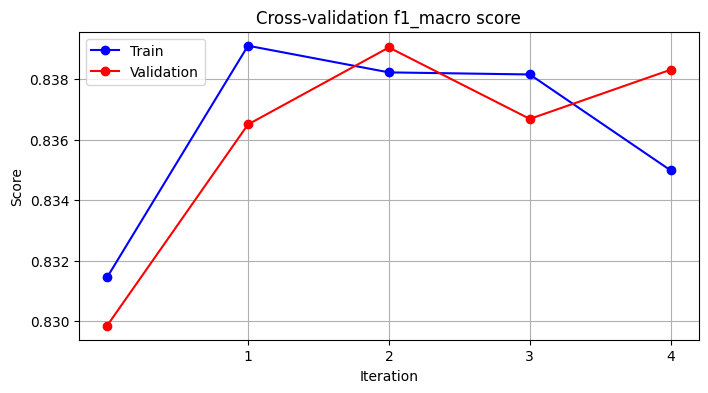

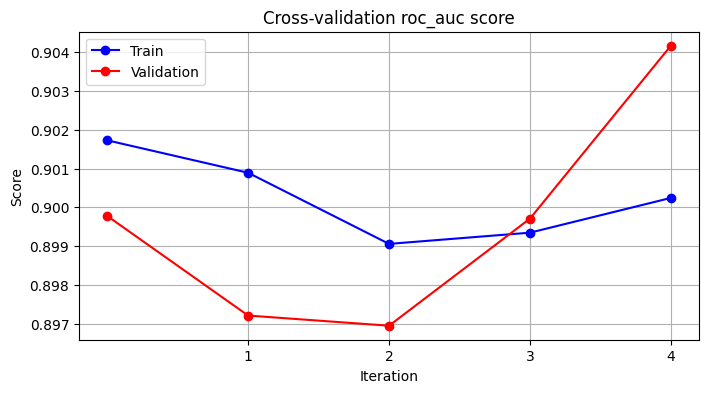

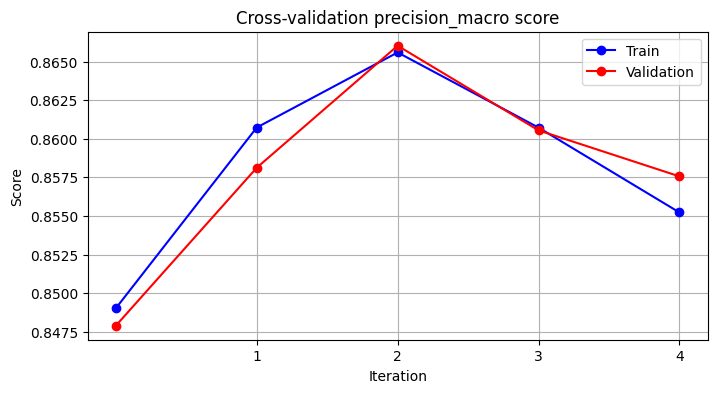

In [77]:
cv_results_rf_clf_tuning = cross_validate(estimator=rf_clf_tuning,
                                          X=X_train,
                                          y=y_train,
                                          scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                          cv=parameters_rf_clf.get('cross_validation')['folders'],
                                          verbose=0,
                                          return_train_score=True,
                                          error_score=np.nan
                                          )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf_tuning[f'train_{score}'].mean().round(4)
    cv_train_std  = cv_results_rf_clf_tuning[f'train_{score}'].std().round(4)
    cv_test_mean  = cv_results_rf_clf_tuning[f'test_{score}'].mean().round(4)
    cv_test_std   = cv_results_rf_clf_tuning[f'test_{score}'].std().round(4)
    plot_cross_validation_score(cv_results_rf_clf_tuning, score)
    print(f'>>>>>>>>> CV {score} train: mean {cv_train_mean}, std {cv_train_std}')
    print(f'>>>>>>>>> CV {score} test:  mean {cv_test_mean},  std {cv_test_std}')

In [78]:
y_val_pred_proba_rf_clf_tuning = rf_clf_tuning.predict_proba(X_val)
df_y_val_pred_proba_rf_clf_tuning = pd.DataFrame(y_val_pred_proba_rf_clf_tuning,
                                   columns=['proba_non_event', 'proba_event'])
df_y_val_pred_proba_rf_clf_tuning.head()

,proba_non_event,proba_event
0,0.751033,0.248967
1,0.169794,0.830206
2,0.670043,0.329957
3,0.565308,0.434692
4,0.480970,0.519030


In [79]:
df_metrics_rf_clf_tuning = calculate_metrics_range_cutoff(df_y_val_pred_proba_rf_clf_tuning, y_true=y_val)
df_metrics_rf_clf_tuning.head()

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate
0,0.05,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325
1,0.07,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325
2,0.09,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325
3,0.11,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325
4,0.13,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325


In [80]:
plot_metrics(df_metrics_rf_clf_tuning)

Accuracy:        0.81
Precision:       0.80
Recall:          0.82
F1-score:        0.81
Specificity:     0.80
AUC:             0.81

TN:              11731.00
TP:              11615.00
FN:              2588.00
FP:              2858.00

FP rate:         19.59%
FN rate:         18.22%
False clf rate:  18.91%



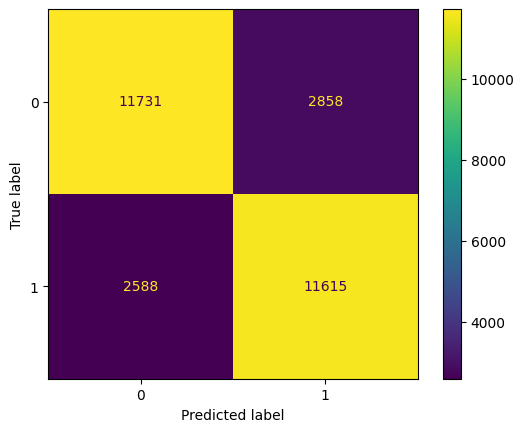

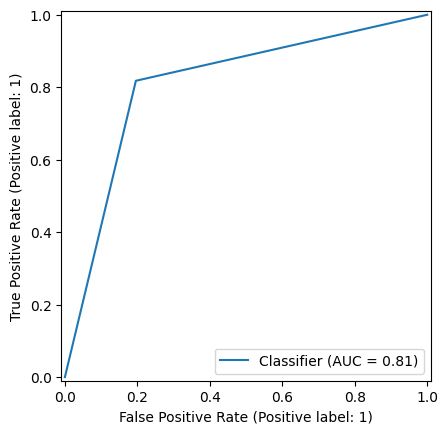

In [81]:
selected_cutoff_rf_clf_tuning = 0.41
df_metrics_selected_cutoff_rf_clf_tuning = calculate_metrics_selected_cutoff(df_y_val_pred_proba_rf_clf_tuning,
                                                                             y_true=y_val,
                                                                             cutoff=selected_cutoff_rf_clf_tuning
                                                                             )

### Feature importance

,feature,importance
12,PC34,0.000275
13,PC35,0.000474
14,PC22,0.000681
15,PC20,0.000942
16,PC2,0.002777


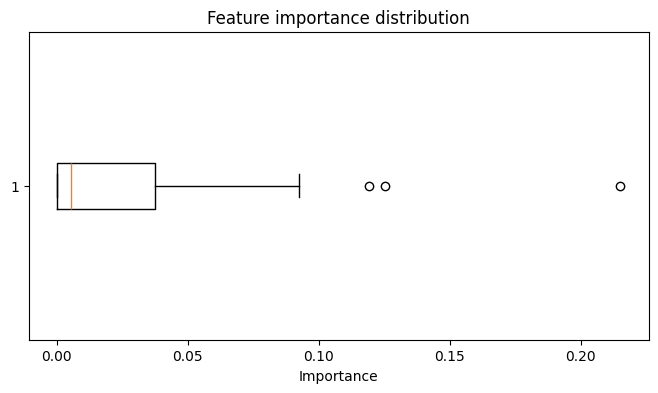

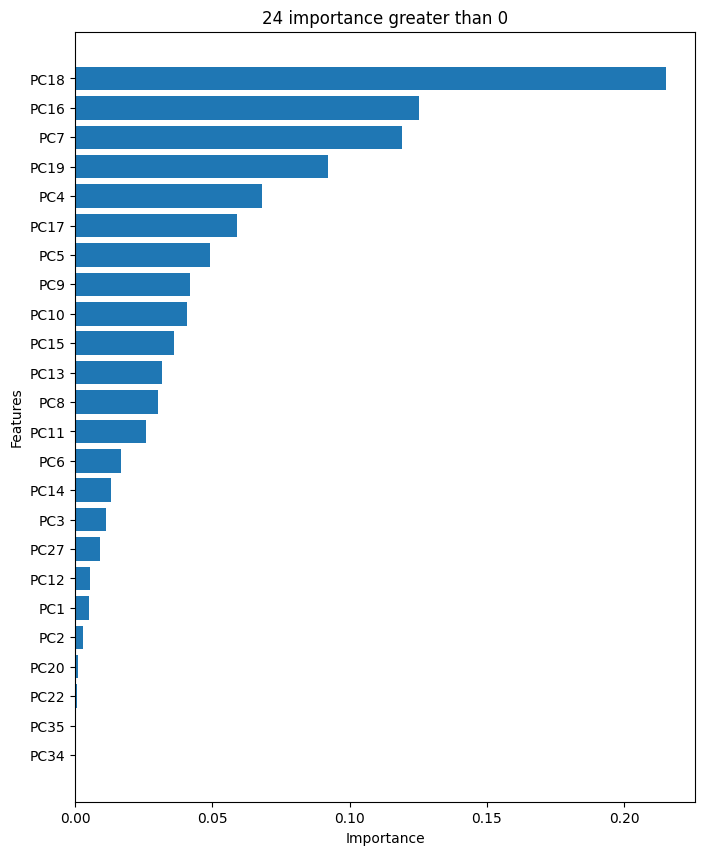

In [82]:
df_feat_importance_rf_clf = calculate_feature_importance(rf_clf_tuning, importance=0)
df_feat_importance_rf_clf.head()

In [83]:
important_features_rf_clf         = df_feat_importance_rf_clf['feature'].to_list()
X_train_important_features_rf_clf = X_train[important_features_rf_clf]

rf_clf_tuning.fit(X_train_important_features_rf_clf, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=2,
                       min_samples_split=0.30000000000000004, n_estimators=125)

### Cross-validation scores

[CV] END .................................................... total time=  11.0s
[CV] END .................................................... total time=  10.2s
[CV] END .................................................... total time=  12.7s
[CV] END .................................................... total time=  14.0s
[CV] END .................................................... total time=  14.6s
>>>>>>>>> CV recall train: mean 0.7204, std 0.0039
>>>>>>>>> CV recall test:  mean 0.7199,  std 0.0067
>>>>>>>>> CV f1_macro train: mean 0.8311, std 0.0033
>>>>>>>>> CV f1_macro test:  mean 0.8307,  std 0.0041
>>>>>>>>> CV roc_auc train: mean 0.8963, std 0.0019
>>>>>>>>> CV roc_auc test:  mean 0.8961,  std 0.0031
>>>>>>>>> CV precision_macro train: mean 0.8512, std 0.0048
>>>>>>>>> CV precision_macro test:  mean 0.8509,  std 0.0053


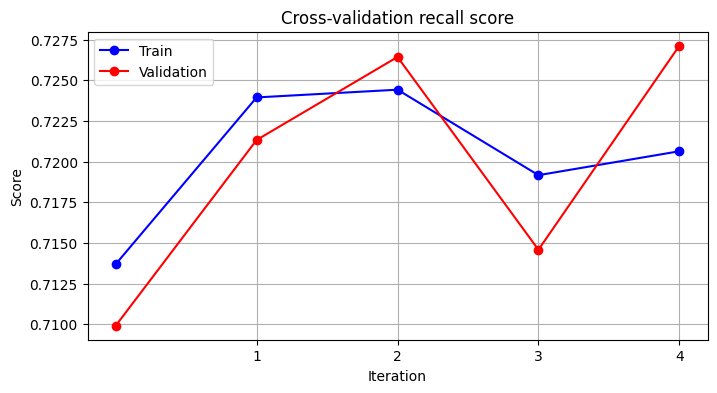

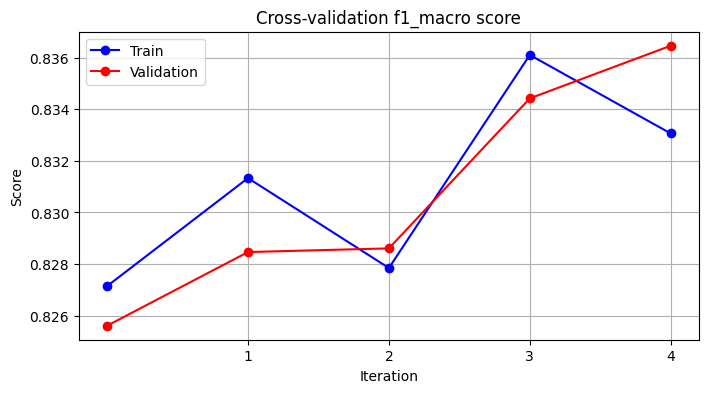

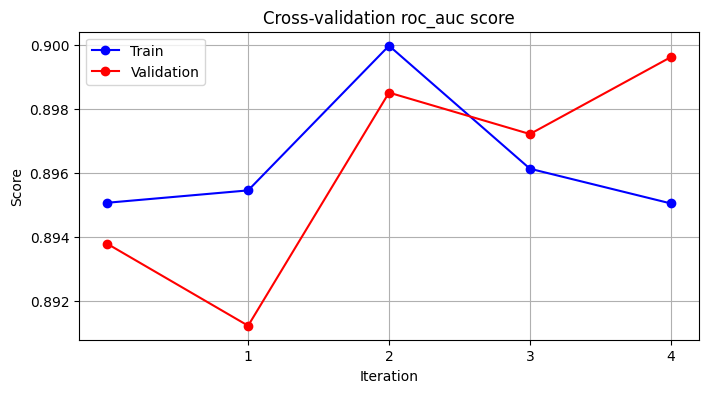

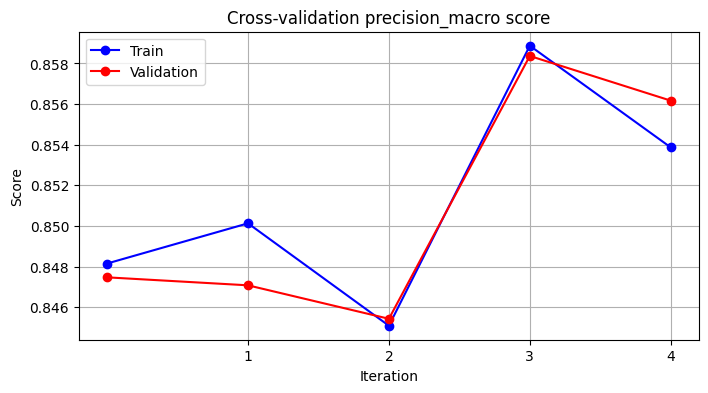

In [85]:
cv_results_rf_clf_imp_features = cross_validate(estimator=rf_clf_tuning,
                                                X=X_train_important_features_rf_clf,
                                                y=y_train,
                                                scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                                cv=parameters_rf_clf.get('cross_validation')['folders'],
                                                verbose=2,
                                                return_train_score=True,
                                                error_score=np.nan
                                                )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf_imp_features[f'train_{score}'].mean().round(4)
    cv_train_std  = cv_results_rf_clf_imp_features[f'train_{score}'].std().round(4)
    cv_test_mean  = cv_results_rf_clf_imp_features[f'test_{score}'].mean().round(4)
    cv_test_std   = cv_results_rf_clf_imp_features[f'test_{score}'].std().round(4)
    plot_cross_validation_score(cv_results_rf_clf_imp_features, score)
    print(f'>>>>>>>>> CV {score} train: mean {cv_train_mean}, std {cv_train_std}')
    print(f'>>>>>>>>> CV {score} test:  mean {cv_test_mean},  std {cv_test_std}')

In [88]:
y_val_pred_proba_rf_clf_imp_features = rf_clf_tuning.predict_proba(X_val[important_features_rf_clf])
df_y_val_pred_proba_rf_clf_imp_features = pd.DataFrame(y_val_pred_proba_rf_clf_imp_features,
                                                       columns=['proba_non_event', 'proba_event'])
df_y_val_pred_proba_rf_clf_imp_features.head()

,proba_non_event,proba_event
0,0.762162,0.237838
1,0.160232,0.839768
2,0.687142,0.312858
3,0.586597,0.413403
4,0.492147,0.507853


In [89]:
df_metrics_rf_clf_imp_features = calculate_metrics_range_cutoff(df_y_val_pred_proba_rf_clf_imp_features, y_true=y_val)
df_metrics_rf_clf_imp_features.head()

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate
0,0.05,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325
1,0.07,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325
2,0.09,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325
3,0.11,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325
4,0.13,0.493297,0.493297,1.0,0.660681,0.5,0,14589,0,14203,0.0,100.0,0.0,50.670325


In [90]:
plot_metrics(df_metrics_rf_clf_imp_features)

Accuracy:        0.80
Precision:       0.79
Recall:          0.81
F1-score:        0.80
Specificity:     0.80
AUC:             0.80

TN:              11607.00
TP:              11547.00
FN:              2656.00
FP:              2982.00

FP rate:         20.44%
FN rate:         18.70%
False clf rate:  19.58%



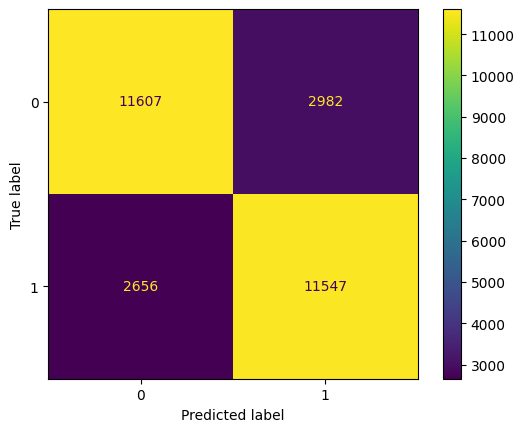

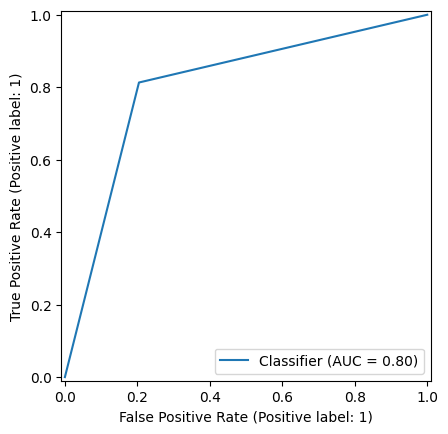

In [91]:
selected_cutoff_rf_clf_imp_features = 0.41
df_metrics_selected_cutoff_rf_clf_imp_features = calculate_metrics_selected_cutoff(df_y_val_pred_proba_rf_clf_imp_features,
                                                                                   y_true=y_val,
                                                                                   cutoff=selected_cutoff_rf_clf_imp_features
                                                                                   )

# Predict

In [94]:
df_test = pd.read_csv('data\original\database_test.csv',
                       encoding='utf-8',
                       sep=','
                      )
df_test['SAFRA_REF'] = pd.to_datetime(df_test['SAFRA_REF']).dt.to_period('M')
df_test['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_test['DATA_EMISSAO_DOCUMENTO'])
df_test['DATA_VENCIMENTO'] = pd.to_datetime(df_test['DATA_VENCIMENTO'])
df_test.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99


In [97]:
df_test.shape

(12275, 6)

In [96]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12275 entries, 0 to 12274
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID_CLIENTE              12275 non-null  int64         
 1   SAFRA_REF               12275 non-null  period[M]     
 2   DATA_EMISSAO_DOCUMENTO  12275 non-null  datetime64[ns]
 3   DATA_VENCIMENTO         12275 non-null  datetime64[ns]
 4   VALOR_A_PAGAR           12275 non-null  float64       
 5   TAXA                    12275 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), period[M](1)
memory usage: 575.5 KB


In [98]:
X_test = df_test.drop(columns='ID_CLIENTE')

In [ ]:
y_test_pred_proba_rf_clf = rf_clf.predict_proba(X_test)
df_y_test_pred_proba_rf_clf = pd.DataFrame(y_test_pred_proba_rf_clf,
                                           columns=['proba_non_event', 'proba_event'])
df_y_test_pred_proba_rf_clf.head()